# Converting an invoice to excel

Before running this code first install all dependenciies into new pip/conda enviroment, currently tested on 
Anaconda python 3.8

import sys
!{sys.executable} -m pip install numpy easyocr opencv-python 

In [1]:
import easyocr

In [2]:
from IPython.display import Image

In [3]:
import cv2

In [4]:
import matplotlib.pyplot as plt

In [5]:
from matplotlib.pyplot import figure

In [6]:
reader = easyocr.Reader(["en"])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [7]:
imPath = "spenser-0.jpg"

In [8]:
img = cv2.imread(imPath)

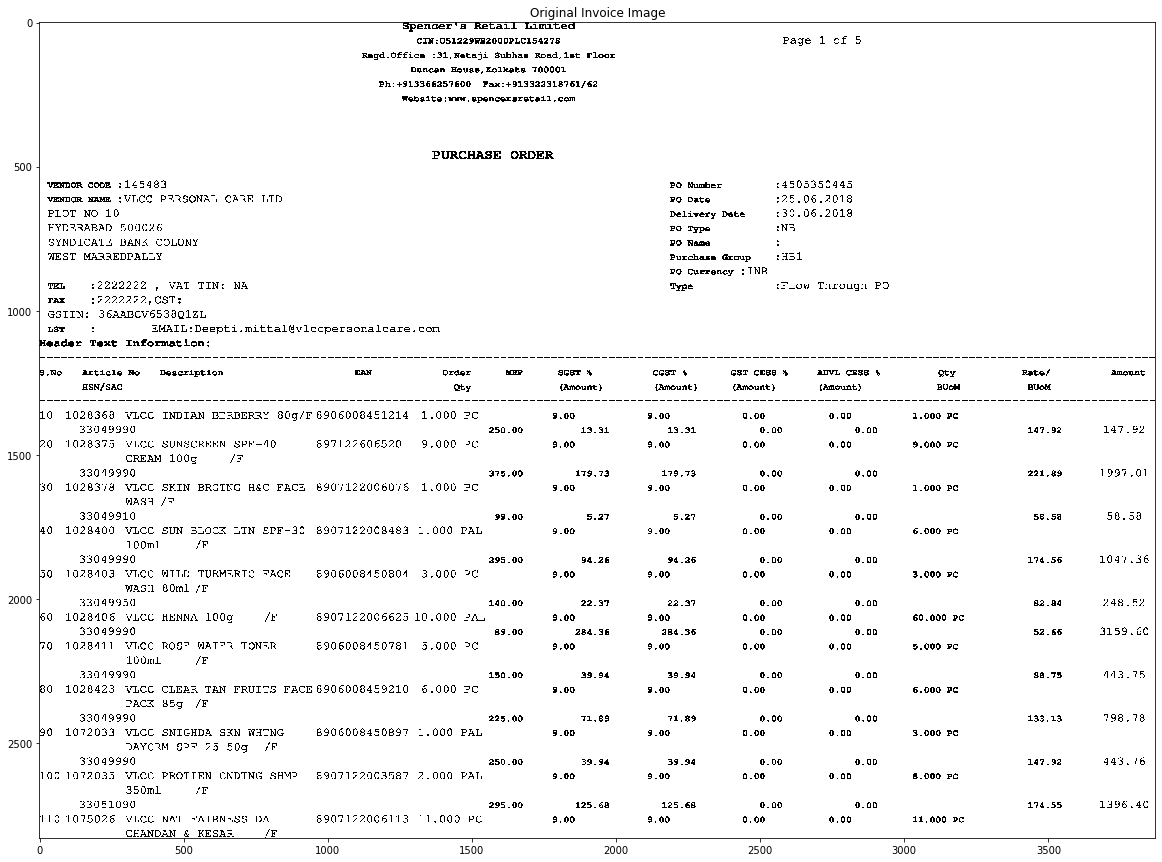

In [9]:
fig = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), interpolation='none')
ax.set_title('Original Invoice Image')
plt.show()

In [10]:
easy_ocr_out = reader.readtext(imPath)

Uncomment following line to see raw output format from easyocr

In [11]:
# easy_ocr_out 

In [12]:
lines_data = []
text = ""

In [13]:
def modifyBoundingBoxData(bounding_box: list):
    """Transform bounding box data as per the convention. EasyOCR return bounding box info in the format
    [left, top, right, top, right, bottom, left, bottom] which is transformed to format
    [{x: left, y: top}, {x: right, y: top}, {x: right, y: bottom}, {x: left, y: bototm}].
    :param bounding_box: Bounding box data form EasyOCR.
    :type bounding_box: list
    :return: [description]
    :rtype: [type]
    """

    arr = bounding_box
    return [
        {"x": arr[0], "y": arr[1]},
        {"x": arr[2], "y": arr[3]},
        {"x": arr[4], "y": arr[5]},
        {"x": arr[6], "y": arr[7]}
    ]

In [14]:
for line in easy_ocr_out:
    confidence = line[2]
    bounding_box_data = line[0]
    line_text = line[1]
    bounding_box_arr = [(bounding_box_data[0][0]), (bounding_box_data[0][1]), (bounding_box_data[1][0]),
                        (bounding_box_data[1][1]), (bounding_box_data[2][0]), (bounding_box_data[2][1]),
                        (bounding_box_data[3][0]), (bounding_box_data[3][1])]

    lines_data.append({
        "confidence": float(round(confidence, 2)),
        "text": line_text,
        "boundingBox": modifyBoundingBoxData(bounding_box_arr)
    })

    text += line_text + "\n"



In [15]:
#lines_data

## Sort all bounding boxes of detected text bounding boxes top to bottom

In [16]:
lines_data

sorted_lines_data = sorted(
    lines_data, key=lambda k: k['boundingBox'][0]['y']
)  # Sort the bounding boxes based on y of the left-top coordinate

## Draw all detected bounding boxes 

In [17]:
def draw_detected_boxes(detection_data, img_draw):
    for detected_text_line in detection_data:
        x1 = int(detected_text_line['boundingBox'][0]['x'])
        y1 = int(detected_text_line['boundingBox'][0]['y'])
        x2 = int(detected_text_line['boundingBox'][2]['x'])
        y2 = int(detected_text_line['boundingBox'][2]['y'])
        #print(x1,y1,x2,y2)
        img_draw = cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0,0,255), -1)

    
    

In [18]:
def show_boxes(img_draw):
    img_draw = cv2.addWeighted(img, 0.4, img_draw, 0.6, 0)
    fig = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    ax.imshow(cv2.cvtColor(img_draw,cv2.COLOR_BGR2RGB), interpolation='none')
    ax.set_title('Detected text bounding boxs')
    plt.show()

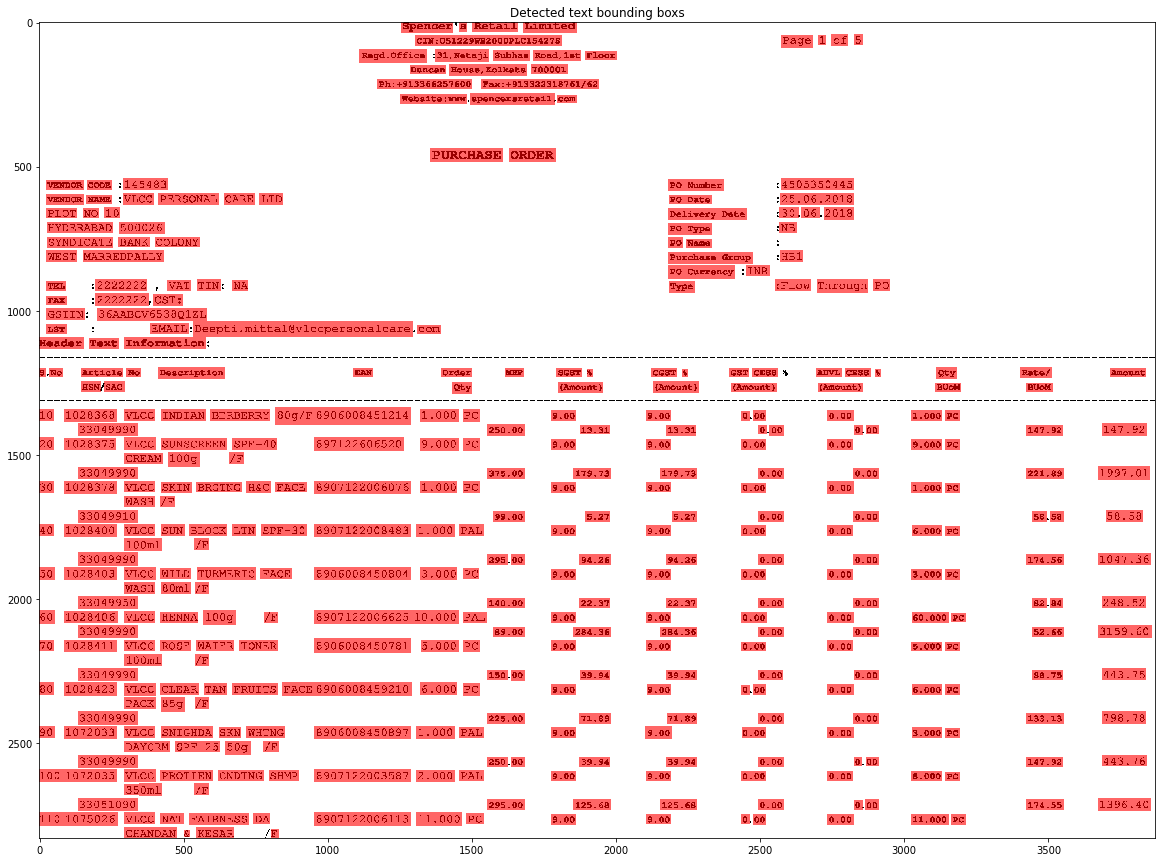

In [19]:
img_draw = img.copy()
draw_detected_boxes(sorted_lines_data, img_draw)
show_boxes(img_draw)

## Combining horizontal text detection bounding boxes 

### Calculate average text char width and height:

In [24]:
total_text_lenght = 0
total_text_width = 0 
total_text_height = 0 
for detected_text_line in sorted_lines_data:
    text_lenght = len(detected_text_line['text'])
    if text_lenght != 0:
        total_text_lenght += text_lenght
        x1 = int(detected_text_line['boundingBox'][0]['x'])
        x2 = int(detected_text_line['boundingBox'][2]['x'])
        y1 = int(detected_text_line['boundingBox'][0]['y'])
        y2 = int(detected_text_line['boundingBox'][2]['y'])
        text_width_in_pixel = (x2-x1)
        text_height_in_pixel = (y2-y1)
        total_text_width += text_width_in_pixel
        total_text_height += text_height_in_pixel

In [25]:
average_text_width_in_pixel = (1.0)*(total_text_width)/(total_text_lenght)
average_text_height_in_pixel = (1.0)*(total_text_height)/(total_text_lenght)

In [26]:
average_text_width_in_pixel,average_text_height_in_pixel

(23.21539961013645, 7.2407407407407405)

### Group detected texts bounding box if they are in same line

In [27]:
def grouper(iterable, interval=2):
    prev = None
    group = []
    for item in iterable:
        #print(item)
        if prev is not None:
            #print(prev)
            yItem = (int(item['boundingBox'][0]['y']) + int(item['boundingBox'][2]['y'])) / 2
            yPrev = (int(prev['boundingBox'][0]['y']) + int(prev['boundingBox'][2]['y'])) / 2
        if not prev or abs(yItem - yPrev) <= interval:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

In [28]:
combined_bboxes = grouper(
    sorted_lines_data, average_text_height_in_pixel
)

In [29]:
# Uncomment for printing grouped text vertically line by line  
#for group in combined_bboxes:
#    print("Group: ", group , "\n\n")

### Group detected bounding boxes from same line if they are less than 2 char width apart

In [30]:
# Sort groups horizonally by x position of bounding box 

In [31]:
sorted_horizontally_groups = []
for group in combined_bboxes:
    #print(group)
    sorted_group = sorted(
                    group, key=lambda k: k['boundingBox'][0]['x']
                    )  # Sort the bounding boxes based on x position of detected boxes 
    sorted_horizontally_groups.append(sorted_group)

In [32]:
def combine_adjacent_boxes(box1,box2):
    if box2 is None:
        return box1
    result_box = {}
    result_box['confidence'] = (box1['confidence'] + box2['confidence'] )/2.0
    #print(box1['text'], box2['text'])
    result_box['text'] = box1['text'] + " " +box2['text'] 
    Box1x1 = int(box1['boundingBox'][0]['x'])
    Box1x2 = int(box1['boundingBox'][2]['x'])
    Box1y1 = int(box1['boundingBox'][0]['y'])
    Box1y2 = int(box1['boundingBox'][2]['y'])
    
    Box2x1 = int(box2['boundingBox'][0]['x'])
    Box2x2 = int(box2['boundingBox'][2]['x'])
    Box2y1 = int(box2['boundingBox'][0]['y'])
    Box2y2 = int(box2['boundingBox'][2]['y'])
    
    resultBoxx1 = Box1x1
    resultBoxx2 = Box2x2
    resultBoxy1 = int(box2['boundingBox'][0]['y'])
    resultBoxy2 = int(box2['boundingBox'][2]['y'])
    
    result_box['boundingBox'] = [{"x": resultBoxx1, "y": resultBoxy1}, 
                                 {"x": resultBoxx2, "y": resultBoxy1},
                                 {"x": resultBoxx2, "y": resultBoxy2}, 
                                 {"x": resultBoxx1, "y": resultBoxy2}]
    return result_box

In [33]:
def compare_horiz_distance_between_adjacenent_box(box1,box2):
    Box1x2 = int(box1['boundingBox'][2]['x'])
    Box2x1 = int(box2['boundingBox'][0]['x'])
    if (Box2x1 - Box1x2) <=  average_text_width_in_pixel:
        return True
    else:
        return False

In [34]:
import copy

In [35]:
trimmed_sorted_horizontally_groups = copy.deepcopy(sorted_horizontally_groups)

In [44]:
#for group in trimmed_sorted_horizontally_groups:
#    for entry in group:
#        print(entry['text'])
#    print("\n\n")

In [37]:
for group in trimmed_sorted_horizontally_groups:
    #group[:] =  [i if True else i for i in it]
    
    atLeastOneMerge = False
    firstRun = True
    while atLeastOneMerge or firstRun:
        firstRun = False
        atLeastOneMerge = False
        result_group = []
        for idx, _ in enumerate(group):
            #print("idx", idx)
            if idx == len(group) - 1:
                result_group.append(group[idx])
            else:
                if compare_horiz_distance_between_adjacenent_box(group[idx],group[idx+1]):
                    #result_group.append(combine_adjacent_boxes(group[idx],group[idx+1]))
                    group[idx] = combine_adjacent_boxes(group[idx],group[idx+1])
                    group.pop(idx+1)
                    atLeastOneMerge = True
                    break
        #group = result_group


In [45]:
#for group in trimmed_sorted_horizontally_groups:
#    for entry in group:
#        print(entry['text'])
#    print("\n\n")

### Output boxes after horizontally combining them  

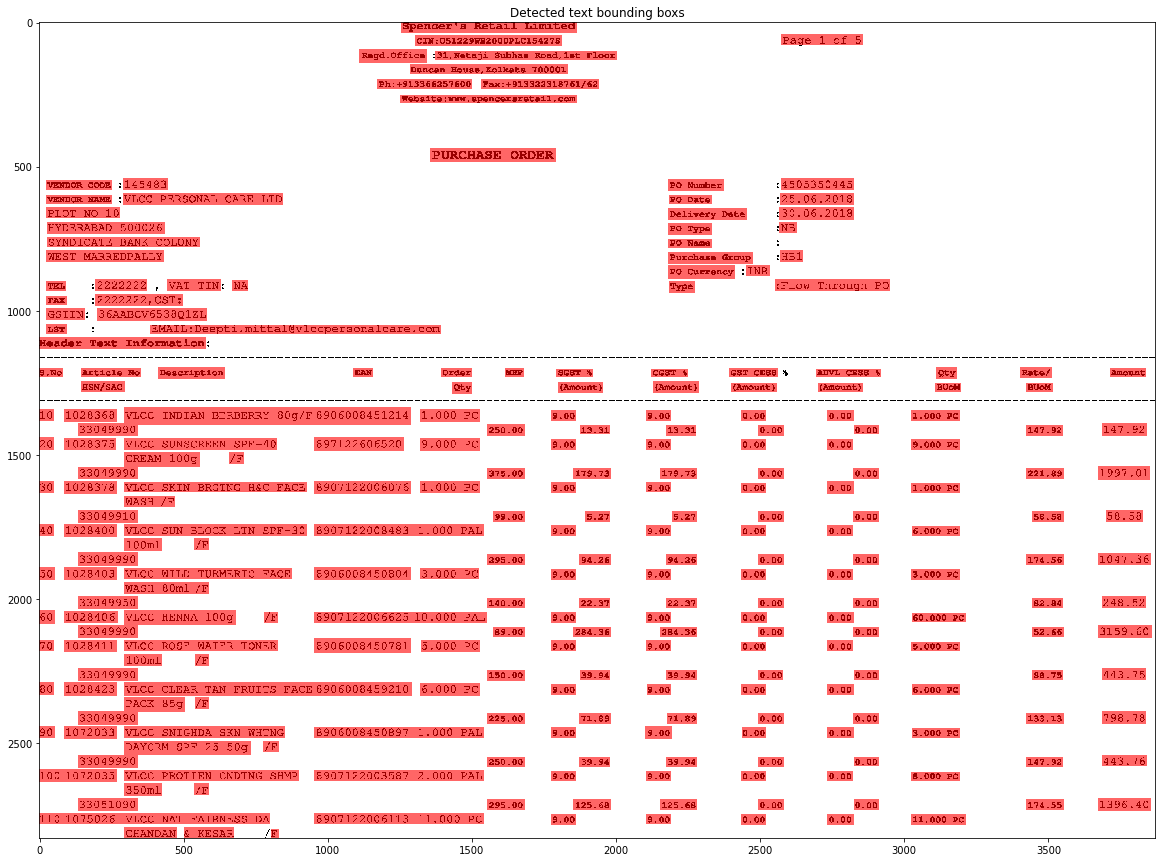

In [46]:
img_draw = img.copy()
for group in trimmed_sorted_horizontally_groups:
    draw_detected_boxes(group, img_draw)
show_boxes(img_draw)

### Export to excel  

In [47]:
from xlsxwriter.workbook import Workbook

In [48]:
workbook = Workbook("reciept_scan_result" + '.xlsx')
worksheet = workbook.add_worksheet()
worksheet.set_column(0, 5, 50)


0

In [49]:
for r, group in enumerate(trimmed_sorted_horizontally_groups):
    for c, entry in enumerate(group):
        worksheet.write(r, c, entry['text'])


In [50]:
workbook.close()

## TODO: 
1. Find better way to combine horizontal detetection boxes, 
2. Figure out way to align column vertically